# Build migration flow diagram between districts in Madrid

Complete the dataset of migration matrix between districts by considering total number of inhabitants per year.

Flow diagram was built with http://app.rawgraphs.io/

In [1]:
import pandas as pd
import warnings
from IPython.display import Image
warnings.filterwarnings("ignore")

In [5]:
# Load data source
census = pd.read_csv("../feature_extraction/data/complete_clean_census_madrid.csv")
census_total = census[census["Unnamed: 0"]=="Total"].loc[:,["district","year","total"]]

migrations = pd.read_csv("../feature_extraction/data/madrid_internal_migrations.csv")

# Drop internal migrations since they are not of our interest
migrations = migrations[migrations["destination"] != migrations["origin"]]
migrations = migrations.dropna()

In [6]:
migrations.head()

,origin,destination,count,year
1,Centro,Arganzuela,1156,2004
2,Centro,Retiro,354,2004
3,Centro,Salamanca,521,2004
4,Centro,Chamartín,328,2004
5,Centro,Tetuán,493,2004


### Calculate district degrees

In [7]:
# Calculate inner degree per district/year
inner_degree = migrations.groupby(["destination","year"], as_index=False).sum().rename(columns={"count":"d_inner",
                                                                                        "destination":"district"})
outer_degree = migrations.groupby(["origin","year"], as_index=False).sum().rename(columns={"count":"d_outer",
                                                                                        "origin":"district"})

# Build complete migration set
mig_move = census_total.merge(inner_degree, left_on=["district","year"], right_on=["district","year"])
mig_move = mig_move.merge(outer_degree, left_on=["district","year"], right_on=["district","year"])
mig_move = mig_move.sort_values(by="year").reset_index(drop=True)

### Calculate flows external -> district and district -> external

In [8]:
# Missing/External = Total inhabitants of year Yi - Total inhabitants of year Yi-1 + "immigrants" - "emigrants"
results = []
for i, df in mig_move.groupby(["district"]):
    balance = []
    balance.append(0)
    years = df.year.tolist()
    for year in years[1:]:
        initial = df[df["year"] == year-1]["total"].values[0]
        inner = df[df["year"] == year]["d_inner"].values[0]
        outer = df[df["year"] == year]["d_outer"].values[0]
        total = df[df["year"] == year]["total"].values[0]
        missing = total - initial + inner - outer
        balance.append(missing)
    df.loc[:,"balance"] = balance
    results.append(df)
    
results_df = pd.concat(results)
results_df["balance_positive"] = results_df["balance"].apply(lambda x: 0 if x < 0 else x)
results_df["balance_negative"] = results_df["balance"].apply(lambda x: 0 if x > 0 else x*(-1))

results_df.to_csv("../feature_extraction/data/migrations_degree_madrid.csv", encoding="utf-8", index=False)

###### Build external -> district and district -> external interactions

In [9]:
external_dist = results_df.loc[:,("district","year","balance_positive")].rename(columns={"district":"destination",
                                                                                        "balance_positive":"count"})
dist_external = results_df.loc[:,("district","year","balance_negative")].rename(columns={"district":"origin",
                                                                                        "balance_negative":"count"})
# Build migrations from and to external (out of Madrid or births/deaths)
dist_external["destination"] = "external"
external_dist["origin"] = "external"

migrations_complete = pd.concat([migrations, external_dist, dist_external])
migrations_complete.to_csv("../feature_extraction/data/migrations_complete_madrid.csv", encoding="utf-8", index=False)

###### Correct district names 

In [11]:
migrations_complete.origin = migrations_complete.origin.replace("Fuencarral-El Pardo","Fuencarral - El Pardo")
migrations_complete.origin = migrations_complete.origin.replace("Moncloa-Aravaca","Moncloa - Aravaca")
migrations_complete.origin = migrations_complete.origin.replace("San Blas-Canillejas","San Blas - Canillejas")
migrations_complete.destination = migrations_complete.destination.replace("Fuencarral- El Pardo","Fuencarral - El Pardo")
migrations_complete.destination = migrations_complete.destination.replace("Moncloa- Aravaca","Moncloa - Aravaca")
migrations_complete.destination = migrations_complete.destination.replace(' Usera','Usera')
migrations_complete.destination = migrations_complete.destination.replace('San Blas- Canillejas','San Blas - Canillejas')

###### Replace districts by the next aggregation level: level of income (high, middle, low) and the location (centre, suburbs)

In [12]:
node_modularity_class = {'Arganzuela':"middle_centre", 'Barajas':"high_suburbs", 'Carabanchel':"low_suburbs", 
 'Centro':"middle_centre", 'Chamartín':"high_centre",
       'Chamberí':"high_centre", 'Ciudad Lineal':"high_suburbs", 
 'Fuencarral - El Pardo':"high_suburbs", 'Hortaleza':"high_suburbs",
       'Latina':"middle_centre", 'Moncloa - Aravaca':"high_suburbs", 
 'Moratalaz':"middle_suburbs", 'Puente de Vallecas':"low_suburbs",
       'Retiro':"high_centre", 'Salamanca':"high_centre", 
 'San Blas - Canillejas':"middle_suburbs", 'Tetuán':"middle_centre", 
 'Usera':"low_suburbs",'Vicálvaro':"low_suburbs", 'Villa de Vallecas':"low_suburbs", 
                         'Villaverde':"low_suburbs","external":"external"}

In [13]:
migrations_complete["origin"] = migrations_complete["origin"].apply(lambda x: node_modularity_class[x])
migrations_complete["destination"] = migrations_complete["destination"].apply(lambda x: node_modularity_class[x])

### Build migration flow including initial number of inhabitants in 2003/2004

In [14]:
# Add total number of inhabitants in 2003-4
sel_census = census_total[census_total["year"]==2004]
sel_census["district_class"] = sel_census["district"].apply(lambda x: node_modularity_class[x])
sel_census = sel_census.loc[:,("district_class","total")].groupby(["district_class"], as_index=False).sum()
sel_census["origin"] = sel_census["district_class"]
sel_census = sel_census.rename(columns={"total":"count","district_class":"destination"})
sel_census["year"] = 2003

In [15]:
migrations_complete_ = pd.concat([migrations_complete,sel_census]).reset_index(drop=True)

In [16]:
migrations_complete_ = migrations_complete_.sort_values(by="year")

In [17]:
years = migrations_complete_.year.unique().tolist()

In [18]:
all_year = []
first = True
for y in years:
    df = migrations_complete_[migrations_complete_.year == y].copy()
    
    # The units in the migration flow diagram will be per each 100 migrants
    df['migration_unit'] = (df['count'] / 100).round().astype(int)
    l = []
    for idx, row in df.iterrows():
        for i in range(row['migration_unit']):
            l.append({y:row['origin'], y+1:row['destination']})
    df2 = pd.DataFrame().from_records(l)
    
    df2[f'i_{y+1}'] = 1
    df2[f'i_{y+1}'] = df2.groupby(y+1)[f'i_{y+1}'].cumsum()
    df2[f'i_{y}'] = 1
    df2[f'i_{y}'] = df2.groupby(y)[f'i_{y}'].cumsum()
    all_year.append(df2)
    if first:
        alldf = df2
        first = False
    else:
        alldf = alldf.merge(df2, left_on=[y, f'i_{y}'], right_on=[y, f'i_{y}'], how="outer")
        w = alldf[y+1].isna()
        alldf.loc[w, y+1] = alldf.loc[w, y]
        alldf[f'i_{y+1}'] = 1
        alldf[f'i_{y+1}'] = alldf.groupby(y+1)[f'i_{y+1}'].cumsum()

In [19]:
complete = alldf[years].fillna(method='backfill', axis=1)
sr = complete.apply(lambda sr: sr.value_counts()).max(1)
sr = sr[sr < 20]
rename = {name: 'other' for name in sr.index}

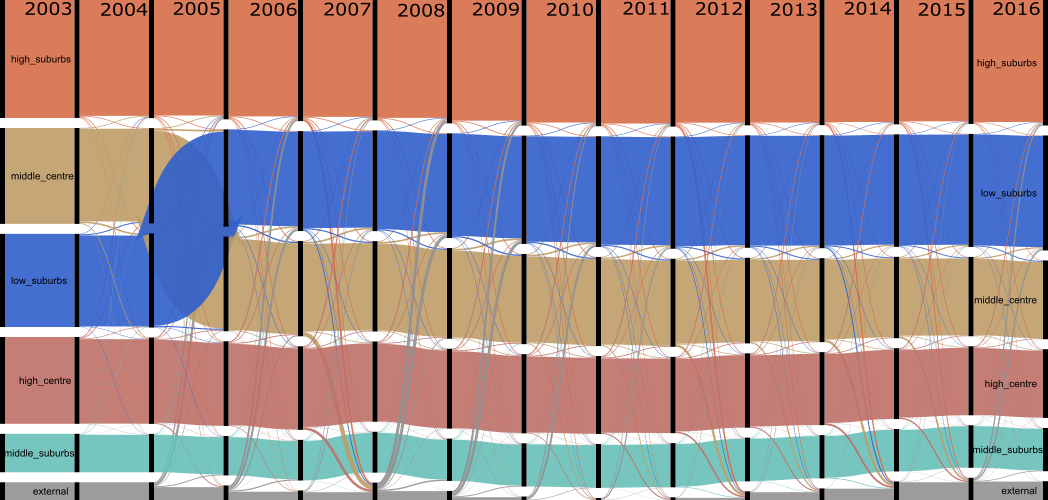

In [20]:
Image("../img/absolute_migrations.png")

In [21]:
complete.to_csv("./data/migrations_madrid.csv", index=False, encoding="utf-8")

### Build migration flow considering initially only the total number of inhabitants that will be involved on migrations

In [22]:
migrations_relat = migrations_complete.sort_values(by="year")

In [23]:
migrations_relat.head(2)

,count,destination,origin,year
1,1156,middle_centre,middle_centre,2004
331,101,low_suburbs,high_suburbs,2004


In [24]:
years = migrations_relat.year.unique().tolist()

In [25]:
all_year = []
first = True
for y in years:
    df = migrations_relat[migrations_relat.year == y].copy()
    
    # The units in the migration flow diagram will be per each 100 migrants
    df['migration_unit'] = (df['count'] / 100).round().astype(int)
    l = []
    for idx, row in df.iterrows():
        for i in range(row['migration_unit']):
            l.append({y:row['origin'], y+1:row['destination']})
    df2 = pd.DataFrame().from_records(l)
    
    df2[f'i_{y+1}'] = 1
    df2[f'i_{y+1}'] = df2.groupby(y+1)[f'i_{y+1}'].cumsum()
    df2[f'i_{y}'] = 1
    df2[f'i_{y}'] = df2.groupby(y)[f'i_{y}'].cumsum()
    all_year.append(df2)
    if first:
        alldf = df2
        first = False
    else:
        alldf = alldf.merge(df2, left_on=[y, f'i_{y}'], right_on=[y, f'i_{y}'], how="outer")
        w = alldf[y+1].isna()
        alldf.loc[w, y+1] = alldf.loc[w, y]
        alldf[f'i_{y+1}'] = 1
        alldf[f'i_{y+1}'] = alldf.groupby(y+1)[f'i_{y+1}'].cumsum()

In [26]:
relative = alldf[years].fillna(method='backfill', axis=1)
sr = relative.apply(lambda sr: sr.value_counts()).max(1)
sr = sr[sr < 20]
rename = {name: 'other' for name in sr.index}

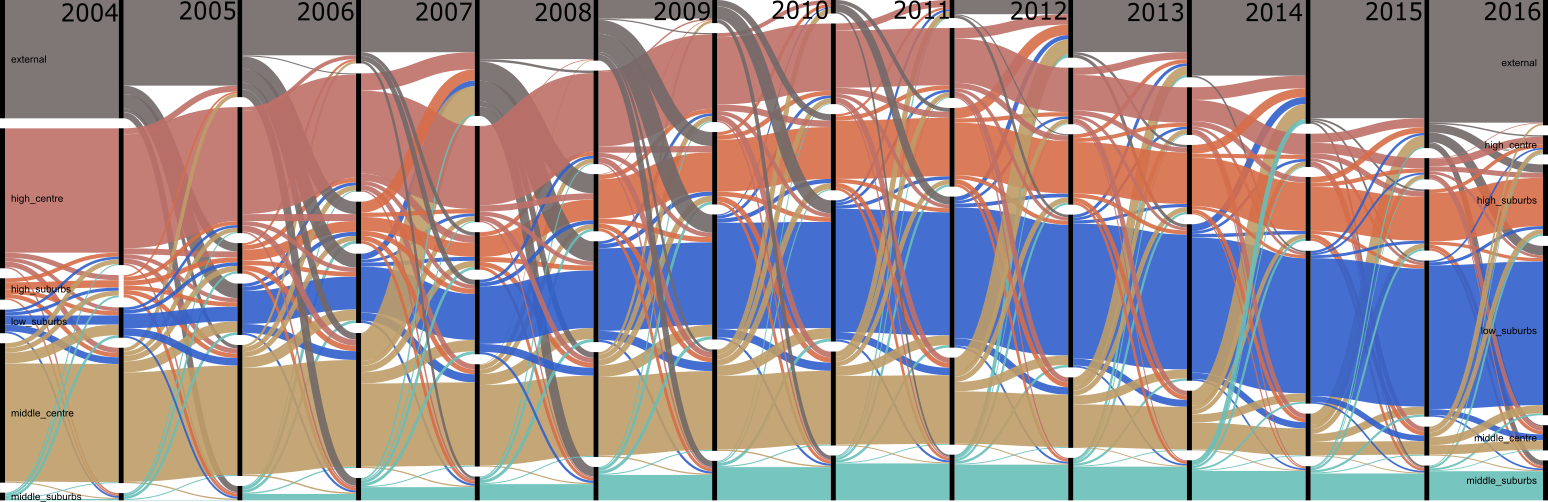

In [27]:
Image("../img/relative_migrations.png")

In [28]:
relative.to_csv("./data/relative_migrations_madrid.csv", index=False, encoding="utf-8")